In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import seaborn as sns
import itertools
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold

In [2]:
# Training Images
train_paths = glob.glob("training/**/*.jpg", recursive=True) # list of paths for all images in training folder
train_images = [cv2.imread(path, 0) for path in train_paths] # list of training images
train_labels = [path.split("\\")[1] for path in train_paths] # list of training image labels
# converting to numpy array
train_images = np.array(train_images)
train_labels = np.array(train_labels)

print("Shape of train_images: ", train_images.shape)
print("Shape of train_labels: ", train_labels.shape)
print("Number of Unique Labels: ", len(np.unique(train_labels)))

Shape of train_images:  (100, 150, 150)
Shape of train_labels:  (100,)
Number of Unique Labels:  4


In [3]:
# testing Images
test_paths = glob.glob("testing/**/*.jpg", recursive=True) # list of paths for all images in testing folder
test_images = [cv2.imread(path, 0) for path in test_paths] # list of testing images
test_labels = [path.split("\\")[1] for path in test_paths] # list of testing image labels
# converting to numpy array
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print("Shape of test_images: ", test_images.shape)
print("Shape of test_labels: ", test_labels.shape)
print("Number of Unique Labels: ", len(np.unique(test_labels)))

Shape of test_images:  (40, 150, 150)
Shape of test_labels:  (40,)
Number of Unique Labels:  4


In [4]:
# Label Encoding Labels ['CR', 'CRP', 'CRT', 'CRTP'] -> [0 , 1, 2, 3]
le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
test_labels_enc = le.transform(test_labels)

In [5]:
x_train, y_train, x_test, y_test = train_images, train_labels_enc, test_images, test_labels_enc

In [6]:
def feature_extractor(image_list: np.ndarray, distances: list, angles: list):
    """ Extract Gray-Level Co-occerance Matrix (GLCM) Features 
        Parameters
        ----------
        image_list -> numpy array of images
        distances  -> list of distances (graycomatrix parameter) 
        angles     -> list of angles    (graycomatrix parameter)

        Returns
        ----------
        Pandas Dataframe of Image features of size I  * (D * A) where,
        I -> Number of images
        D -> Number of distances
        A -> Number of Angles
    """
    img_features_df = pd.DataFrame() # empty dataframe to append feature values
    
    # iterate through each image
    for img in image_list:
        df = pd.DataFrame() # empty dataframe store feature values for 'img' 
        params = list(itertools.product(distances, angles)) # possible pairs of distances and angles
        # glcm_features = ["energy", "correlation", "dissimilarity", "homogeinity", "contrast", "ASM"]

        # iterate for each distance and angle pair, calculate glcm and extract features
        for (d, ang) in params:
            GLCM = graycomatrix(img, [d], [np.deg2rad(ang)])
            df["Correlation_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "correlation")[0]
            df["Dissimilarity_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "dissimilarity")[0]
            df["Homogeneity_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "homogeneity")[0]
            df["Contrast_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "contrast")[0]
            df["ASM_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "ASM")[0]
            df["Energy_"+str(d)+"_"+str(ang)] = graycoprops(GLCM, "energy")[0]
        
        img_features_df =  pd.concat([img_features_df, df], ignore_index=True) # append extracted features

    return img_features_df

In [7]:
# Define GLCM Features parameters distances and angles
dists = [1, 2, 3, 4] # distances
angs  = [0, 45, 90, 135] # angles

In [8]:
x_features = feature_extractor(x_train, dists, angs) # generate glcm features for training data
scaler = StandardScaler()
x_features[x_features.columns] = scaler.fit_transform(x_features[x_features.columns]) # Scaling Features

In [9]:
print("Shape of GLCM Features for Training: ", x_features.shape)
x_features

Shape of GLCM Features for Training:  (100, 96)


,Correlation_1_0,Dissimilarity_1_0,Homogeneity_1_0,Contrast_1_0,ASM_1_0,Energy_1_0,Correlation_1_45,Dissimilarity_1_45,Homogeneity_1_45,Contrast_1_45,...,Homogeneity_4_90,Contrast_4_90,ASM_4_90,Energy_4_90,Correlation_4_135,Dissimilarity_4_135,Homogeneity_4_135,Contrast_4_135,ASM_4_135,Energy_4_135
0,-1.126581,-1.335068,1.144631,-1.280457,1.818058,1.775963,-1.088562,-1.426842,1.133758,-1.375570,...,1.592706,-1.544461,2.266309,2.188434,-0.892900,-1.724300,1.854367,-1.533657,2.287111,2.210126
1,-0.665040,-1.968588,2.166509,-1.655787,3.410594,2.989806,-0.763916,-2.004108,2.251462,-1.724587,...,2.635142,-1.704566,3.625229,3.217478,-1.459676,-2.050449,2.747300,-1.727354,3.677146,3.261661
2,-1.010395,-0.389622,-0.146223,-0.598154,0.136004,0.230035,-1.075026,-0.444658,-0.156545,-0.651911,...,0.498183,-0.945337,0.439694,0.548052,-1.004450,-0.860150,0.497431,-0.926507,0.460440,0.570207
3,-1.735040,-1.400695,1.125321,-1.303081,2.298448,2.161880,-1.721253,-1.482198,1.289317,-1.403063,...,1.683606,-1.589969,2.852279,2.647528,-1.295723,-1.862470,2.005596,-1.614859,2.910238,2.697588
4,-0.113717,-0.931235,0.577405,-0.992412,0.420214,0.518278,0.014328,-1.035883,0.555196,-1.098591,...,0.179031,-0.976678,0.369188,0.476161,-1.614874,-0.628506,-0.242490,-0.813030,0.392587,0.501094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.168589,0.189275,-0.209046,0.154925,-0.427896,-0.387953,0.002393,0.039173,-0.134869,0.002303,...,0.121013,-0.271293,-0.302174,-0.254802,0.470548,-0.175602,-0.036577,-0.245262,-0.315211,-0.270967
96,0.431054,-0.337762,0.195426,-0.374969,-0.249796,-0.185286,0.484463,-0.353186,0.213178,-0.405994,...,0.051755,-0.388803,-0.342744,-0.302080,0.719829,-0.298713,0.259661,-0.390755,-0.335895,-0.295153
97,0.572204,-0.600051,0.376744,-0.671362,-0.117338,-0.039257,0.629580,-0.637498,0.078045,-0.711390,...,0.280653,-0.489964,-0.187663,-0.123476,0.276475,-0.318703,-0.115368,-0.470591,-0.229953,-0.172369
98,1.032656,-1.048495,0.754711,-1.087717,0.173322,0.268676,1.068353,-1.054713,0.878742,-1.097206,...,0.231344,-0.762290,-0.094255,-0.018555,0.481664,-0.506319,0.037775,-0.674147,-0.145283,-0.076128


In [10]:
# Predict on Test data
# Extract features from test data and reshape, just like training data
test_features = feature_extractor(x_test, dists, angs)
test_features[test_features.columns] = scaler.transform(test_features[test_features.columns]) # Scaling Features

In [11]:
print("Shape of GLCM Features for testing: ", test_features.shape)

Shape of GLCM Features for testing:  (40, 96)


In [12]:
# LightGBM Model Training
d_train = lgb.Dataset(x_features, label=y_train)
d_test = lgb.Dataset(test_features, label=y_test)

# https://lightgbm.readthedocs.io/en/latest/Parameters.html

lgbm_params = {
              'learning_rate':0.05, 
              'boosting_type':'dart',    
              'objective':'multiclass',
              'metric': 'multi_logloss',
              'num_leaves': 100,
              'max_depth': 10,
              'num_class':4, 
            }  

lgb_model = lgb.train(lgbm_params, d_train, 100) 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3360
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 96
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [13]:
# Prediction
train_prediction = lgb_model.predict(x_features)
train_prediction=np.argmax(train_prediction, axis=1) # get the class with the highest probability value
test_prediction = lgb_model.predict(test_features)
test_prediction = np.argmax(test_prediction, axis=1) # get the class with the highest probability value

In [14]:
# Inverse le transform to get original label back. 
train_prediction = le.inverse_transform(train_prediction)
test_prediction = le.inverse_transform(test_prediction)

In [15]:
# Classfication Report
print("Classification Report on Training Set")
print("-"*50)
print(classification_report(train_labels, train_prediction, digits=4))
print("Classification Report on Test Set")
print("-"*50)
print(classification_report(test_labels, test_prediction, digits=4))

Classification Report on Training Set
--------------------------------------------------
              precision    recall  f1-score   support

          CR     0.9615    1.0000    0.9804        25
         CRP     1.0000    0.9600    0.9796        25
         CRT     1.0000    1.0000    1.0000        25
        CRTP     0.9600    0.9600    0.9600        25

    accuracy                         0.9800       100
   macro avg     0.9804    0.9800    0.9800       100
weighted avg     0.9804    0.9800    0.9800       100

Classification Report on Test Set
--------------------------------------------------
              precision    recall  f1-score   support

          CR     0.9000    0.9000    0.9000        10
         CRP     0.9000    0.9000    0.9000        10
         CRT     1.0000    1.0000    1.0000        10
        CRTP     1.0000    1.0000    1.0000        10

    accuracy                         0.9500        40
   macro avg     0.9500    0.9500    0.9500        40
weighted av

In [16]:
def gen_annotations(cf_matrix):
    """
    Generates Annotation for each cell in confusion matrix
    args:
        cf_matrix: confusion matrix (numpy array)
    """
    sums = np.sum(cf_matrix, axis=1, keepdims=True) # sum of each row
    cf_perc = 100*cf_matrix/sums # converting to percentage
    annot = np.empty_like(cf_matrix).astype(str) # creating a empty numpy array to store annotations for each cell
    # iterate through each cell and store the annotation
    rows, cols = cf_matrix.shape 
    for i in range(rows):
        for j in range(cols):
            val = cf_matrix[i, j]
            perc_val = cf_perc[i, j]
            if val == 0: 
                annot[i, j] = '0'
            else:
                sum_val = sums[i][0]
                annot[i, j] = "%.1f%%\n(%d/%d)" % (perc_val, val, sum_val)
    return annot   

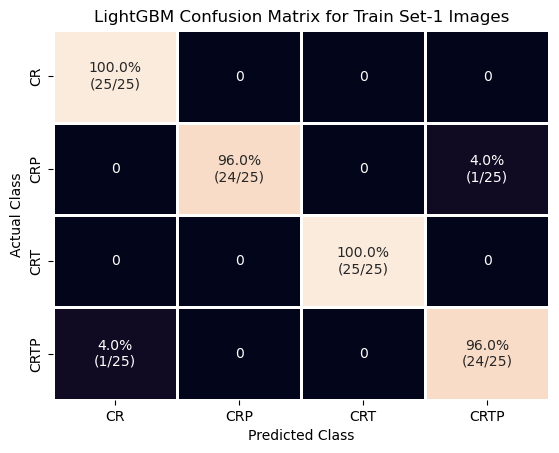

In [17]:
# Plot confusion matrix Training Set-1
cm = confusion_matrix(train_labels, train_prediction)
annot = gen_annotations(cm)
fig = sns.heatmap(cm, annot=annot, linewidth=1, fmt='', cbar=False,
            xticklabels=['CR', 'CRP', 'CRT', 'CRTP'],
            yticklabels=['CR', 'CRP', 'CRT', 'CRTP']).get_figure()

plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('LightGBM Confusion Matrix for Train Set-1 Images')
plt.show()
fig.savefig("plots/lgb/cfmatrix_lgb_train_set_1.png", dpi=600)

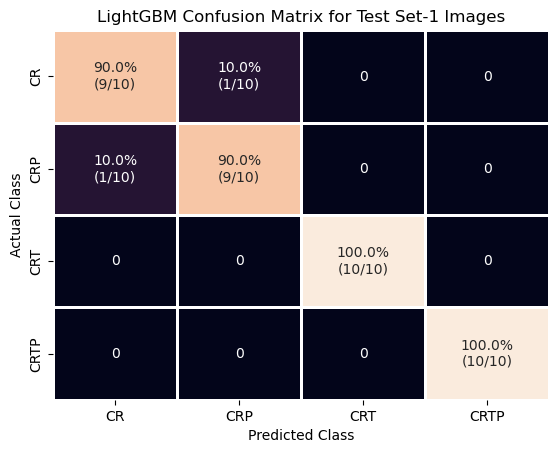

In [18]:
# Plot confusion matrix Testing Set-1
cm = confusion_matrix(test_labels, test_prediction)
annot = gen_annotations(cm)
fig = sns.heatmap(cm, annot=annot, linewidth=1, fmt='', cbar=False,
            xticklabels=['CR', 'CRP', 'CRT', 'CRTP'],
            yticklabels=['CR', 'CRP', 'CRT', 'CRTP']).get_figure()

plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('LightGBM Confusion Matrix for Test Set-1 Images')
plt.show()
fig.savefig("plots/lgb/cfmatrix_lgb_test_set_1.png", dpi=600)

## Shap Analysis

In [19]:
import shap

In [20]:
# get shap values
shap_values = shap.TreeExplainer(lgb_model).shap_values(test_features)

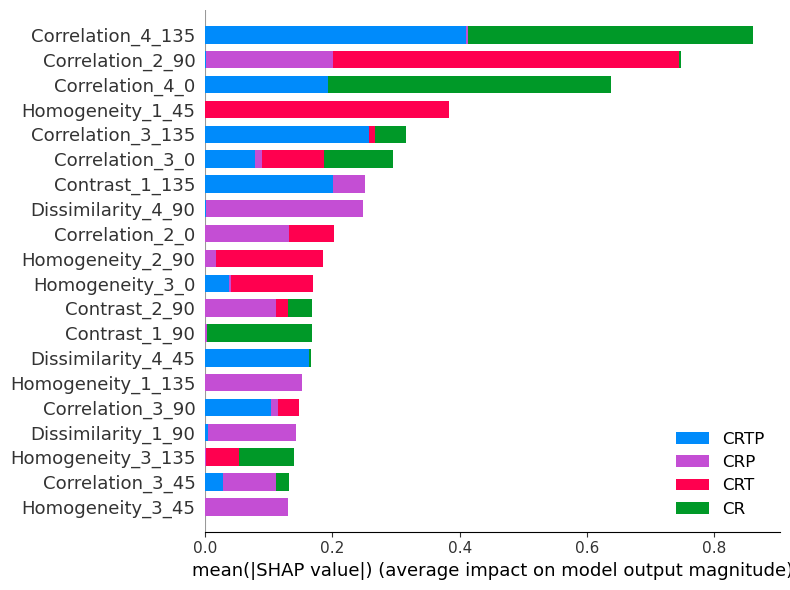

In [21]:
# plot summary
shap.summary_plot(shap_values, test_features, class_names=["CR", "CRP", "CRT", "CRTP"], plot_size=[8,6], show=False)
plt.savefig("plots/lgb/shap_summary_all.png", dpi=600)

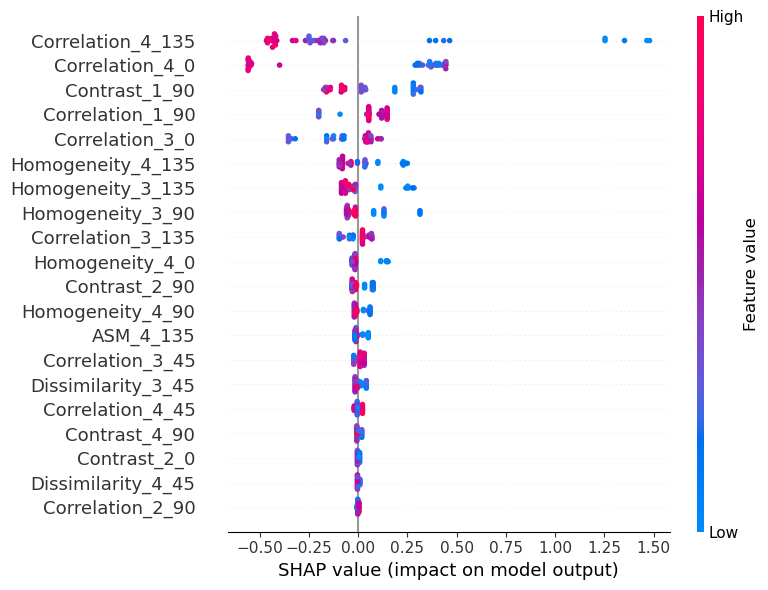

In [22]:
shap.summary_plot(shap_values[0], test_features, plot_size=[8,6], show=False) # summary plot for 'CR' class
plt.savefig("plots/lgb/shap_summary_CR.png", dpi=600)

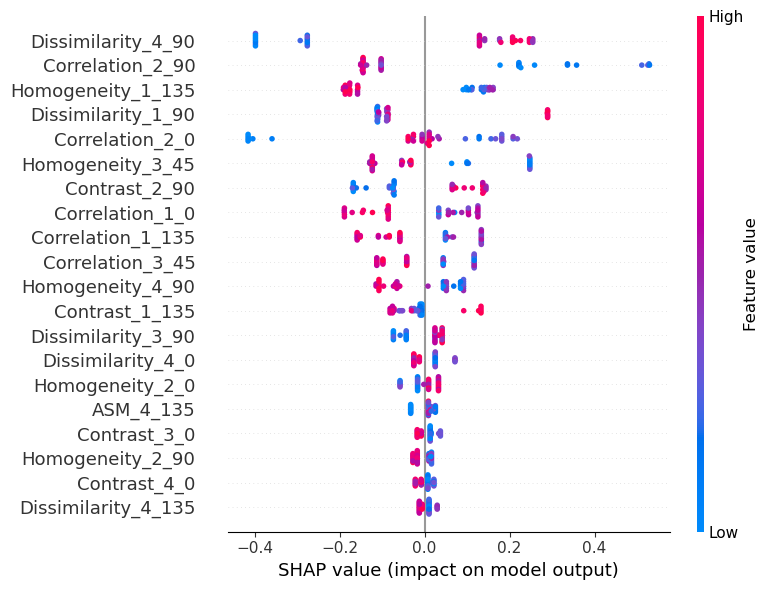

In [23]:
shap.summary_plot(shap_values[1], test_features, plot_size=[8,6], show=False) # summary plot for 'CRP' class
plt.savefig("plots/lgb/shap_summary_CRP.png", dpi=600)

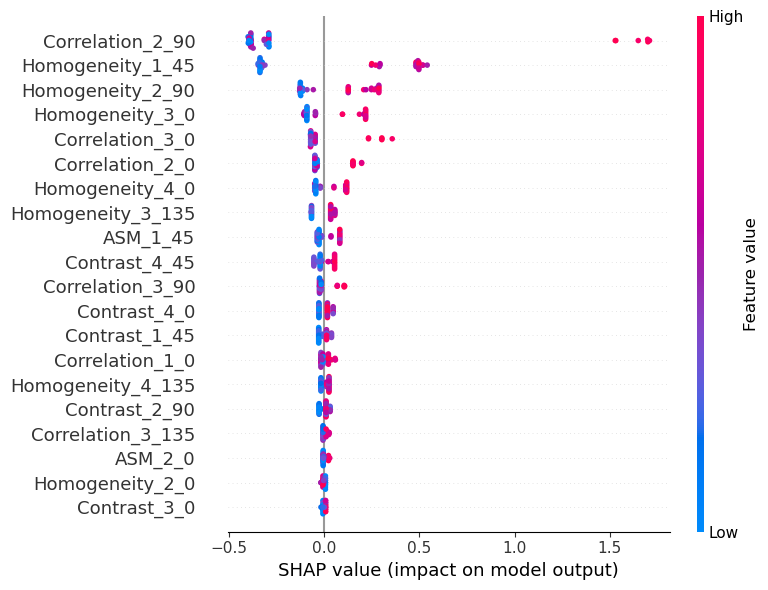

In [24]:
shap.summary_plot(shap_values[2], test_features, plot_size=[8,6], show=False) # summary plot for 'CRT' class
plt.savefig("plots/lgb/shap_summary_CRT.png", dpi=600)

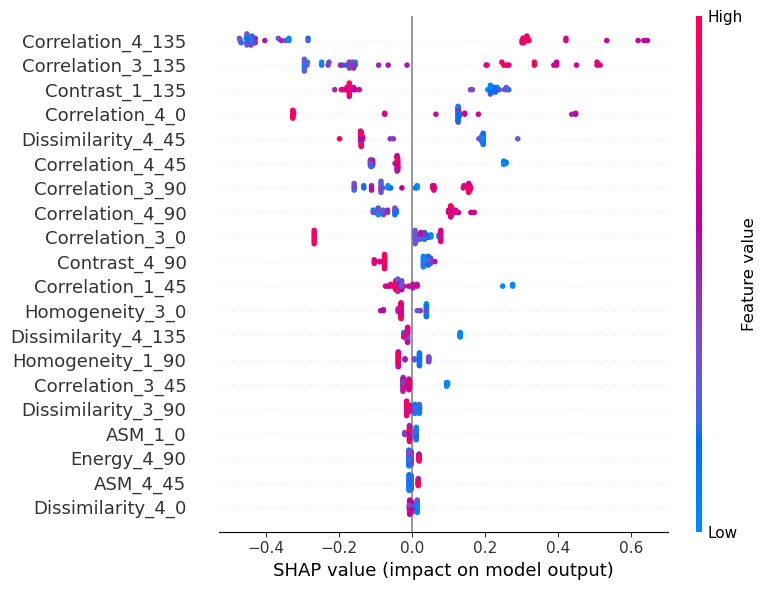

In [25]:
shap.summary_plot(shap_values[3], test_features, plot_size=[8,6], show=False) # summary plot for 'CRTP' class
plt.savefig("plots/lgb/shap_summary_CRTP.png", dpi=600)

## Cross Validation

In [26]:
# Merge all the training and test image features and labels
all_features = pd.concat([x_features, test_features], ignore_index=True)
all_labels_enc = np.append(train_labels_enc, test_labels_enc)

In [27]:
folds = 10
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
acc_per_fold = []
# iterate through each fold
for train_idx, test_idx in kf.split(all_features, y = all_labels_enc):
    X_train, X_test = all_features.iloc[train_idx], all_features.iloc[test_idx]
    y_train, y_test = all_labels_enc[train_idx], all_labels_enc[test_idx]
    # Create datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    # train model     
    model = lgb.train(lgbm_params, train_data, 100)
    # predict label probability
    y_pred = model.predict(X_test)
    # get the class with the highest probability
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred_labels)
    acc_per_fold.append(acc)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4193
[LightGBM] [Info] Number of data points in the train set: 126, number of used features: 96
[LightGBM] [Info] Start training from score -1.402295
[LightGBM] [Info] Start training from score -1.370546
[LightGBM] [Info] Start training from score -1.402295
[LightGBM] [Info] Start training from score -1.370546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [28]:
# Average Accuracy Score
avg_acc =  np.mean(acc_per_fold)
print(f'Average Accuracy: {avg_acc:.4f}')

Average Accuracy: 0.8143
